<a href="https://colab.research.google.com/github/sefeoglu/DeepLearningProjectsandKaggleCompetitions/blob/master/Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Information about the Group
**Goup Name :** Overfitters

**Names:**


Sefika Efeoglu

**Please add your name here!**

put the drive folder to yours...

[Drive folder link](https://drive.google.com/drive/folders/1iR7rhVijYAx2whWOoJu43pxbdXaYvR5h?usp=sharing)


the archive.zip folder was broken on my repo, so
please change the archive.zip as format mask->annotations and images

### Installations

In [ ]:
!pip install pyyaml==5.1
!pip install imgaug>=0.2.5
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version


     |████████████████████████████████| 276kB 9.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44076 sha256=ffd30f60e162494ccad2f8737e8fab5a1b90c40ceeddbf865fe3955b951b3ec0
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 1.7MB/s 
     |████████████████████████████████| 2.2MB 13.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201213-cp36-none-any.whl size=40711 sha256=ea7306188ea7e724e69e02321150de23231b6ed3368d4a1e5cf3ec67e8e2c440
  Stored in directory: /root/.cache/pip/wheels/20/eb/f9/b537cf42e3b4c57fe2a49aecad264c775df2d89e0ffbf5b17d
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10505 sha256=fd3f3495398c2e083488b4cc227b5295518e2e3e8ba639e68dece77b4515982f
  Stored in directory: /root/.cache/pip/wheels/9e/01/e4/1b68f5a2a6b9450ea4246d91840a77e1169f7d4722d76bbc47
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.

### Libraries

Definition of the necessary libraries

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



DataSet Link : [Mask Dataset](http://kaggle.com/andrewmvd/face-mask-detection/download)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [ ]:
from zipfile import ZipFile 
import pandas as pd
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup as bs

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/mask/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import shutil
import matplotlib.pyplot as plt


path_cpy = "mask"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp drive/MyDrive/CompetitionDL/archive.zip sample_data/
!cp drive/MyDrive/CompetitionDL/DatasetSplit.csv sample_data/
!unzip sample_data/archive.zip

## Load Data and split it to train and test set

**Helper functions**

In [ ]:
def gen_box(obj):
#     Getting bounding box coordinates
    xmin = int(obj.find('xmin').text)
    xmax = int(obj.find('xmax').text)
    ymin = int(obj.find('ymin').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def gen_label(obj):
    if obj.find('name').text == "with_mask":
        return "mask" #     for without_mask label set to 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return "incorrect_mask"     # for mask_weared_incorrect label set to 2
    return "no_mask" #     for without_mask label set to 0

**Getting Data from xml file**

In [ ]:
def gen_list(path):
    coordinates = []
    labels = []
    name= []
    size = []
    xml_list  = list(sorted(os.listdir(path+"/annotations")))
    img_list = list(sorted(os.listdir(path+"/images")))
    total = len(img_list)
    #assert len(img_list) == len(xml_list)
    counter = 0
    for xml in xml_list:
      with open(path+f"/annotations/{xml}") as file:
        data = file.read()
        soup = bs(data, "xml")
        xml_objs = soup.find_all('object')
        counter +=1
        for i in xml_objs:
          coordinates.append(gen_box(i))
          labels.append(gen_label(i))
          name.append(soup.find('filename').text)
        print(f"file processed {counter} / {total}...")
    return coordinates, name, labels, size

In [ ]:
coordinates, name, labels, size = gen_list(path_cpy)

**Making DataFrame from data extracted from XML**

In [ ]:
def initialize_frame(df, name, labels):
  df['name'] = name
  df['labels'] = labels
  # initializing labels
  df['xmin'] = 0
  df['ymin'] = 0
  df['xmax'] = 0
  df['ymax'] = 0
  df['height'] = np.zeros(len(df['name']))
  df['width'] = np.zeros(len(df['name']))

**Assigning values to columns**


In [ ]:
def assign_value_dataframe(df, coordinates):

  for i,(xmin,ymin,xmax,ymax) in enumerate(coordinates):
    df['xmin'][i] = xmin
    df['ymin'][i] = ymin
    df['xmax'][i] = xmax
    df['ymax'][i] = ymax

  for i,fname in enumerate(name):
    img = cv2.imread(path_cpy+'/images/'+fname)
    height = img.shape[0]
    width = img.shape[1]
    df['height'][i] = height
    df['width'][i] = width

In [ ]:
df = DataFrame()
initialize_frame(df, name, labels)
assign_value_dataframe(df, coordinates)

In [ ]:
df.head()

,name,labels,xmin,ymin,xmax,ymax,height,width
0,maksssksksss0.png,no_mask,79,105,109,142,366.0,512.0
1,maksssksksss0.png,mask,185,100,226,144,366.0,512.0
2,maksssksksss0.png,no_mask,325,90,360,141,366.0,512.0
3,maksssksksss1.png,mask,321,34,354,69,156.0,400.0
4,maksssksksss1.png,mask,224,38,261,73,156.0,400.0


**Splitting Data into Train and Test set**

In [ ]:
datasetSplit = pd.read_csv("sample_data/DatasetSplit.csv",delimiter=",")

In [ ]:
datasetSplit 

,Unnamed: 0,0
0,xml train:,"['maksssksksss0.xml', 'maksssksksss100.xml', '..."
1,img train:,"['maksssksksss0.png', 'maksssksksss100.png', '..."
2,xml validation:,"['maksssksksss1.xml', 'maksssksksss121.xml', '..."
3,img validation:,"['maksssksksss1.png', 'maksssksksss121.png', '..."
4,xml test:,"['maksssksksss10.xml', 'maksssksksss103.xml', ..."
5,img test:,"['maksssksksss10.png', 'maksssksksss103.png', ..."


In [ ]:
train_files = datasetSplit["0"][1][2:-2].replace("', '", ",").split(',')
test_files = datasetSplit["0"][5][2:-2].replace("', '", ",").split(',')
val_files = datasetSplit["0"][3][2:-2].replace("', '", ",").split(',')

In [ ]:
train_df = df[df.name.isin(train_files)]
test_df = df[df.name.isin(test_files)]
val_df = df[df.name.isin(val_files)]
classes = df.labels.unique().tolist()

In [ ]:
train_df.head(5)

,name,labels,xmin,ymin,xmax,ymax,height,width
0,maksssksksss0.png,no_mask,79,105,109,142,366.0,512.0
1,maksssksksss0.png,mask,185,100,226,144,366.0,512.0
2,maksssksksss0.png,no_mask,325,90,360,141,366.0,512.0
13,maksssksksss100.png,mask,189,30,245,88,226.0,400.0
14,maksssksksss100.png,mask,387,54,400,75,226.0,400.0


# **Visualisation Steps**

We visualize the number of images in our dataset according their labels.

All data

Text(0.5, 0.98, 'Overview of all')

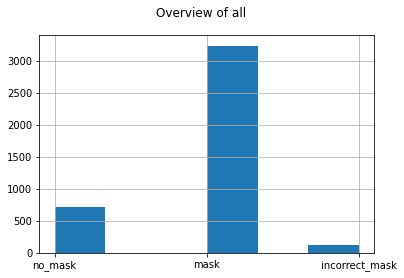

In [ ]:
df.labels.hist(bins=6)
plt.suptitle("Overview of all")

Text(0.5, 0.98, 'Overview of Training Dataset')

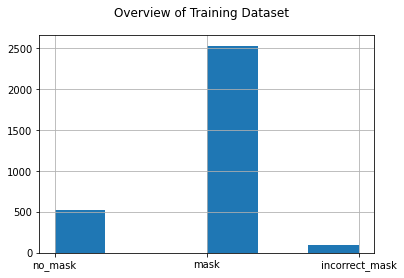

In [ ]:
train_df.labels.hist(bins=6)
plt.suptitle("Overview of Training Dataset")

Text(0.5, 0.98, 'Overview of Test Dataset')

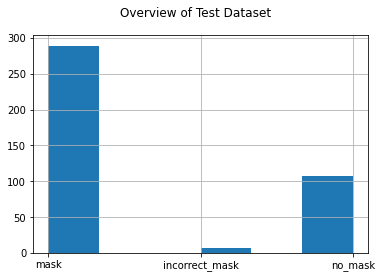

In [ ]:
test_df.labels.hist(bins=6)
plt.suptitle("Overview of Test Dataset")

**Creating function that formats data in COCO Dateset format**

In [ ]:
def my_dataset_function(df,classes):
    data_list = []
    for i,fname in enumerate(df['name'].unique()):
        record = dict()
        #gtetting all rows with nmae as fnmae
        image_df = df[df['name']==fname]
        #image path
        img_path = path_cpy +'/images/'+fname
        #entring recprds
        record['file_name'] = img_path
        record['image_id'] = i
        record['height'] = int(image_df.iloc[0].height)
        record['width'] = int(image_df.iloc[0].width)
        
        objs = []
        for _,row in image_df.iterrows():
          xmin = int(row.xmin)
          ymin = int(row.ymin)
          xmax = int(row.xmax)
          ymax = int(row.ymax)

          poly = [
                  (xmin, ymin), (xmax, ymin),
                  (xmax, ymax), (xmin, ymax)
                  ]
          poly = list(itertools.chain.from_iterable(poly))

          obj = {
              "bbox": [xmin, ymin, xmax, ymax],
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": classes.index(row.labels),
              "iscrowd": 0
              }
          objs.append(obj)
        record["annotations"] = objs
        data_list.append(record)
    return data_list

In [ ]:
len(train_df),len(test_df)

(3149, 404)

In [ ]:
my_dataset_function(train_df, classes)[11]

{'annotations': [{'bbox': [90, 84, 138, 131],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2,
   'iscrowd': 0,
   'segmentation': [[90, 84, 138, 84, 138, 131, 90, 131]]}],
 'file_name': 'mask/images/maksssksksss112.png',
 'height': 400,
 'image_id': 11,
 'width': 267}

In [ ]:
train_df[train_df.name == "maksssksksss112.png"]

,name,labels,xmin,ymin,xmax,ymax,height,width
101,maksssksksss112.png,incorrect_mask,90,84,138,131,400.0,267.0


**Registering Dataset**

In [ ]:
for d in ["train", "val", "test"]:
  if d == "train":
    DatasetCatalog.register("data_" + d, lambda:my_dataset_function(train_df, classes))
    MetadataCatalog.get("data_" + d).set(thing_classes=classes)
  elif d == "val":
    DatasetCatalog.register("data_" + d, lambda:my_dataset_function(val_df, classes))
    MetadataCatalog.get("data_" + d).set(thing_classes=classes)
  else :
    DatasetCatalog.register("data_" + d, lambda:my_dataset_function(test_df, classes))
    MetadataCatalog.get("data_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("data_train")

**Visualize the Training Data Set with Detector 2**

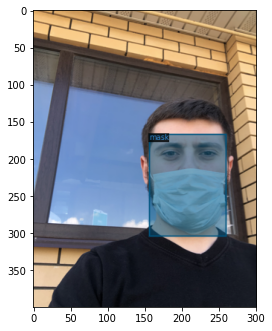

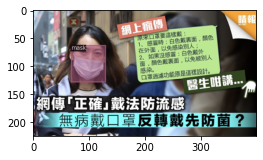

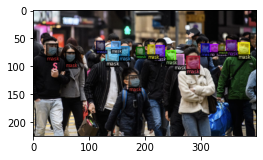

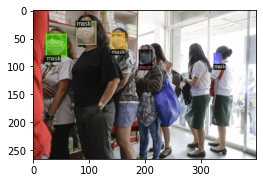

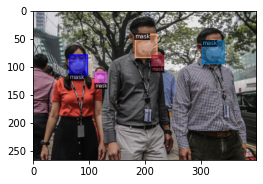

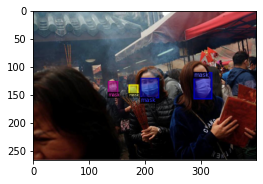

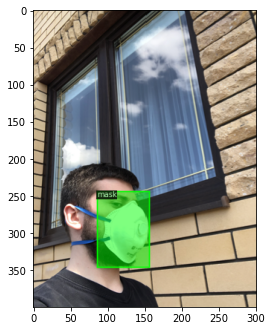

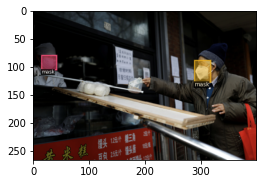

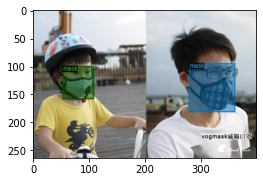

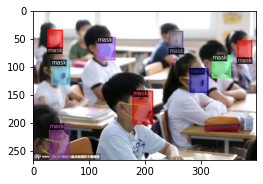

In [ ]:
dataset_dicts = DatasetCatalog.get('data_train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=statement_metadata)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (4, 8))
    plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
statement_metadata

Metadata(name='data_train', thing_classes=['no_mask', 'mask', 'incorrect_mask'])

**Data Augmentation Step**

In [ ]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

[{'annotations': [{'bbox': [98, 267, 194, 383],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1,
    'iscrowd': 0,
    'segmentation': [[98, 267, 194, 267, 194, 383, 98, 383]]}],
  'file_name': 'mask/images/maksssksksss10.png',
  'height': 400,
  'image_id': 0,
  'width': 301},
 {'annotations': [{'bbox': [42, 54, 94, 110],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1,
    'iscrowd': 0,
    'segmentation': [[42, 54, 94, 54, 94, 110, 42, 110]]},
   {'bbox': [188, 46, 236, 106],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1,
    'iscrowd': 0,
    'segmentation': [[188, 46, 236, 46, 236, 106, 188, 106]]},
   {'bbox': [261, 88, 303, 130],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1,
    'iscrowd': 0,
    'segmentation': [[261, 88, 303, 88, 303, 130, 261, 130]]},
   {'bbox': [368, 112, 400, 151],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1,
    'iscrowd': 0,
    'segmentation': [[368, 112, 400, 112, 400, 151, 368, 

# **MASK RNN Model 101**

The first model that we chose is Mask RCCN which has the highest performance among the suggested image recognization model in the literature.

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ("data_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = (1000, 2500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 500


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/14 13:24:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[12/14 13:24:28 d2.engine.train_loop]: Starting training from iteration 0
[12/14 13:25:33 d2.utils.events]:  eta: 2:18:48  iter: 19  total_loss: 2.774  loss_cls: 1.38  loss_box_reg: 0.4767  loss_mask: 0.6962  loss_rpn_cls: 0.2903  loss_rpn_loc: 0.02646  time: 3.2637  data_time: 0.0275  lr: 1.9981e-06  max_mem: 12143M
[12/14 13:26:41 d2.utils.events]:  eta: 2:19:45  iter: 39  total_loss: 2.904  loss_cls: 1.348  loss_box_reg: 0.5482  loss_mask: 0.6929  loss_rpn_cls: 0.2446  loss_rpn_loc: 0.03362  time: 3.3378  data_time: 0.0004  lr: 3.9961e-06  max_mem: 12143M
[12/14 13:27:46 d2.utils.events]:  eta: 2:15:46  iter: 59  total_loss: 2.804  loss_cls: 1.299  loss_box_reg: 0.4802  loss_mask: 0.6848  loss_rpn_cls: 0.2558  loss_rpn_loc: 0.03875  time: 3.3091  data_time: 0.0005  lr: 5.9941e-06  max_mem: 12143M
[12/14 13:28:55 d2.utils.events]:  eta: 2:16:57  iter: 79  total_loss: 2.663  loss_cls: 1.213  loss_box_reg: 0.5092  loss_mask: 0.6731  loss_rpn_cls: 0.2272  loss_rpn_loc: 0.05778  time: 3.

**Train the model with augmented data.**

**<font color="purple">Discussion of the Mask RNN Results for non-augmented data and augmented data:</font>**

**Save the checkpoints**

In [ ]:
torch.save(trainer.model, 'checkpoint.pth')

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

**Evaluation of the Mask RNN Model**



1.   Use cocoevaluate to evaluate the public test dataset.



In [ ]:
evaluator = COCOEvaluator("data_test", cfg, False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "data_test")
evaluate = inference_on_dataset(trainer.model, test_loader, evaluator)

WARNING [12/14 18:37:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[12/14 18:37:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/14 18:37:54 d2.data.common]: Serializing 85 elements to byte tensors and concatenating them all ...
[12/14 18:37:54 d2.data.common]: Serialized dataset takes 0.04 MiB
[12/14 18:37:54 d2.evaluation.evaluator]: Start inference on 85 images
[12/14 18:37:58 d2.evaluation.evaluator]: Inference done 11/85. 0.2905 s / img. ETA=0:00:21
[12/14 18:38:03 d2.evaluation.evaluator]: Inference done 28/85. 0.2951 s / img. ETA=0:00:17
[12/14 18:38:08 d2.evaluation.evaluator]: Inference done 45/85. 0.2949 s / img. ETA=0:00:12
[12/14 18:38:13 d2.evaluation.evaluator]: Inference done 63/85. 0.2890 s / img. ETA=0:00:06
[12/14 18:38:18 d2.evaluation.evaluator]: Inference do

In [ ]:
evaluate.values

<function OrderedDict.values>

In [ ]:
test_df[test_df.name == "maksssksksss292.png"]
im = cv2.imread("mask/images/maksssksksss292.png")
outputs = predictor(im)
instances = outputs["instances"].to("cpu")

In [ ]:
outputs

{'instances': Instances(num_instances=0, image_height=300, image_width=400, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 300, 400), dtype=torch.uint8)])}

# **COCO mAP for the Evaluation of the Public Test Dataset**

In [ ]:
!pip install mean_average_precision
!pip install --upgrade git+https://github.com/bes-dev/mean_average_precision.git

The "**get_preds_and_gt(im)**" function constructs the gt and preds for a given image.




In [ ]:
def get_preds_and_gt(img, d_dict, predictor):
  """
  im : image 
  returns:
        outputs : prediction result
        gt: outputs_gt
  """

  output = predictor(img)
  instances = output["instances"].to("cpu")
  boxes = instances.pred_boxes.tensor.numpy()
  categories = instances.pred_classes.numpy()
  scores = instances.scores.numpy()
  outputs = []
  gt = []
  bbox_list = []
  for a in d_dict['annotations']:
    bbox_list.append(a['bbox'])

  print(instances.pred_classes)
  print(bbox_list)
  print(scores)
  for i, score in enumerate(list(scores)):
    output_line =list(boxes[i])
    output_line.append(list(categories)[i])
    output_line.append(score)
    outputs.append(output_line)

  for i, bbox in enumerate(bbox_list):
    gt_line = bbox
    category_id = d_dict["annotations"][i]['category_id']
    gt_line.append(category_id)
    gt_line.append(0)
    gt_line.append(0)
    gt.append(gt_line)
    
  return np.array(outputs), np.array(gt)


**COCO mAP function**

We developed a custom COCO mAP function evaluate the public test dataset.

In [ ]:
def get_COCO_mAP(metric_fn):
  return metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']
# This methods adapts the prediction and ground truth data to allow a
# correct mAP calculation (from the mean-average-precision library)
def calc_mAP_metric(preds, gt, minScore=0.0):
    """
      preds - predictions in mAP format
      gt    - ground truth in mAP format

      preds format: [ [xmin, ymin, xmax, ymax, class_id, confidence], ... ]
      gt format:    [ [xmin, ymin, xmax, ymax, class_id, difficult, crowd], ... ]

    """
    # Filter out all values smaller than minScore

    preds = preds[preds[:,5] > minScore]
    # First check which classes occur in our prediction & gt data
    classes = np.union1d(np.unique(preds[:,4]), np.unique(gt[:,4]))

    # The MeanAveragePrecision2D calculator expect class from 0 to num_classes-1.
    # Thus, we have to change the classes in our dataset to fit this requirement.
    # The result of the calculation is not influenced by the actual class, as 
    # long as the changes in class are the same for pred and gt.

    # Thus get the smalles class
    minC = np.amin(classes)

    # Adapt the class column of preds and gt by susbtracting the smalles class
    subArrayPred = np.ones(preds.shape[0]) * minC
    subArrayGt = np.ones(gt.shape[0]) * minC
    preds[:,4] = preds[:,4]- subArrayPred
    gt[:,4] = gt[:,4] - subArrayGt

    # To ensure correct mAP calculation create a MeanAveragePrecision2D 
    # instance ONLY with the number of occuring classes in our dataset
    numC = len(classes)
    metric = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=numC)

    # Add the adapted data set and calc the COCO mAP value
    metric.add(preds, gt)
    mAP = get_COCO_mAP(metric)

    # Undo the substraction
    preds[:,4] =  preds[:,4]  + subArrayPred
    gt[:,4] = gt[:,4] + subArrayGt

    return mAP

We are testing the test data set using COCO mAP, and then save the results as json file. Lastly copy the file to drive.

Evaluate the all public test data using custom COCO mAP function ("calc_mAP_metric"), and then save the result to json file

In [ ]:
with open("test_result_2.json", mode='w', encoding='utf-8') as f:
    json.dump("",f)

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer
import json
import pprint
pp = pprint.PrettyPrinter(indent=4)
dataset_dicts = DatasetCatalog.get('data_test')
test_metric = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=3)
for d in dataset_dicts:
  with open("test_result_2.json", mode='a', encoding='utf-8') as feedsjson:
    img = cv2.imread(d["file_name"])
    print(d['file_name'])
    preds, gt = get_preds_and_gt(img,d, predictor)

    if len(preds)== 0: 
      voc_pascal_map, voc_pascal_map_all, coco_map = mAP_of_preds(preds, gt)
    elif len(gt)== 0:
      voc_pascal_map, voc_pascal_map_all, coco_map = mAP_of_preds(preds, gt)
    else:
      coco_map = calc_mAP_metric(preds, gt)
    result_line = {'file_name':d["file_name"],'coco_map':str(coco_map)}
    feedsjson.write(json.dumps(result_line, ensure_ascii=False, indent=4))
    feedsjson.write(",")
    feedsjson.close()

In [ ]:
for i,  d in enumerate(dataset_dicts):
  print(i)
  for a in d['annotations']:
    print(a['bbox'])

**<font color="purple">Discussion of Evaluation Results:</font>**

**Save the test results to drive**

You can change the folder here.

In [ ]:
!cp test_result_2.json drive/MyDrive/Results/
!cp checkpoint.pth drive/MyDrive/Results/
!cp output/metrics.json drive/MyDrive/Results/

# **Use these lines for private test dataset**

If you want to use a new data_set instead of achive.zip

In [ ]:
private_path_cpy ="mask"# write your folder name here

coordinates, name, labels, size = gen_list(private_path_cpy)
private_df = DataFrame()
initialize_frame(private_df,name, labels)
assign_value_dataframe(private_df, coordinates)


If you want to use a dataset from archive.zip, customize the lines below for yourself.
Maybe you should change the DataSetSplit.cv for private dataset

In [ ]:
datasetSplit

,Unnamed: 0,0
0,xml train:,"['maksssksksss0.xml', 'maksssksksss100.xml', '..."
1,img train:,"['maksssksksss0.png', 'maksssksksss100.png', '..."
2,xml validation:,"['maksssksksss1.xml', 'maksssksksss121.xml', '..."
3,img validation:,"['maksssksksss1.png', 'maksssksksss121.png', '..."
4,xml test:,"['maksssksksss10.xml', 'maksssksksss103.xml', ..."
5,img test:,"['maksssksksss10.png', 'maksssksksss103.png', ..."


In [ ]:
private_test_files = datasetSplit["0"][5][2:-2].replace("', '", ",").split(',')
private_test_df = df[df.name.isin(private_test_files)]

Register the private test dataset 

In [ ]:
# Register the private_test_set
DatasetCatalog.register("data_private_test", lambda:my_dataset_function(private_test_df, classes))
MetadataCatalog.get("data_private_test" ).set(thing_classes=classes)

Metadata(name='data_private_test', thing_classes=['no_mask', 'mask', 'incorrect_mask'])

# **Mask RNN 50**

Another model we wanted to train is Fast CNN



In [ ]:
cfg_fcnn = get_cfg()

cfg_fcnn.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
  )
)

cfg_fcnn.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg_fcnn.DATASETS.TRAIN = ("data_train",)
cfg_fcnn.DATASETS.TEST = ("data_val",)
cfg_fcnn.DATALOADER.NUM_WORKERS = 4
cfg_fcnn.SOLVER.IMS_PER_BATCH = 4
cfg_fcnn.SOLVER.BASE_LR = 0.001
cfg_fcnn.SOLVER.WARMUP_ITERS = 1000
cfg_fcnn.SOLVER.MAX_ITER = 2000
cfg_fcnn.SOLVER.STEPS = (1000, 2000)
cfg_fcnn.SOLVER.GAMMA = 0.05
cfg_fcnn.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg_fcnn.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg_fcnn.TEST.EVAL_PERIOD = 500

In [ ]:
os.makedirs(cfg_fcnn.OUTPUT_DIR, exist_ok=True)

trainer_fcnn = CocoTrainer(cfg_fcnn)
trainer_fcnn.resume_or_load(resume=False)
trainer_fcnn.train()

Save the checkpoint of fast cnn model

In [ ]:
torch.save(trainer_fcnn.model, 'checkpoint_rcnn.pth')

In [ ]:
cfg_fcnn.MODEL.WEIGHTS = os.path.join(cfg_fcnn.OUTPUT_DIR, "fcnn_model_final.pth")
cfg_fcnn.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg_fcnn)

In [ ]:
evaluator = COCOEvaluator("data_test", cfg_fcnn, False, output_dir="./output_fcnn/")
test_loader = build_detection_test_loader(cfg_fcnn, "data_test")
inference_on_dataset(trainer_fcnn.model, test_loader, evaluator)

Visualize the image

In [ ]:
import ntpath
outputs = predictor(im)
v = Visualizer(
im[:, :, ::-1],
metadata=statement_metadata,
scale=1.,
instance_mode=ColorMode.IMAGE
)
instances = outputs["instances"].to("cpu")
instances.remove('pred_masks')
v = v.draw_instance_predictions(instances)
result = v.get_image()[:, :, ::-1]
file_name = ntpath.basename('test')

Show the predicted classes and predicted boxes for this image 

In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(result)

# **References**

1. Kaggle solution: 

# **Further Solution For COCO mAP Evaluation**

The COCO mAP Evaluation function calculates the PASCAL VOC metric, PASCAL VOC metric at all points, and COCO metric

In [ ]:
import numpy as np
from mean_average_precision import MetricBuilder


def mAP_of_preds(output_preds, output_gt):

  # create metric_fn
  metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=3)

  for i in range(len(output_preds)):
      metric_fn.add(preds, gt)

  # compute PASCAL VOC metric
  voc_pascal_map =metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']

  # compute PASCAL VOC metric at the all points
  voc_pascal_map_all = metric_fn.value(iou_thresholds=0.5)['mAP']

  # compute metric COCO metric
  coco_map = metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']
  return voc_pascal_map,voc_pascal_map_all, coco_map

In [ ]:
with open("test_result.json", mode='w', encoding='utf-8') as f:
    json.dump("",f)

In [ ]:
dataset_dicts = DatasetCatalog.get('data_test')

for d in dataset_dicts:
  with open("test_result.json", mode='a', encoding='utf-8') as feedsjson:
    img = cv2.imread(d["file_name"])
    preds, gt = get_preds_and_gt(img)


In [ ]:
!cp test_result.json drive/MyDrive/Results/

# **Load Model**

In [ ]:
# Configuration setup for testing
cfg1 = get_cfg()
cfg1.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg1.DATALOADER.NUM_WORKERS = 4
cfg1.DATASETS.TEST = ("data_test", )
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg1.MODEL.WEIGHTS = os.path.join(cfg1.OUTPUT_DIR, "model_final.pth")
cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set the testing threshold for this model

predictor1 = DefaultPredictor(cfg1)

In [ ]:
evaluator1 = COCOEvaluator("data_test", cfg1, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg1, "data_test")
inference_on_dataset(predictor1.model, val_loader, evaluator1)

WARNING [12/14 18:34:46 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[12/14 18:34:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/14 18:34:46 d2.data.common]: Serializing 85 elements to byte tensors and concatenating them all ...
[12/14 18:34:46 d2.data.common]: Serialized dataset takes 0.04 MiB
[12/14 18:34:46 d2.evaluation.evaluator]: Start inference on 85 images
[12/14 18:34:49 d2.evaluation.evaluator]: Inference done 11/85. 0.2824 s / img. ETA=0:00:20
[12/14 18:34:55 d2.evaluation.evaluator]: Inference done 29/85. 0.2853 s / img. ETA=0:00:16
[12/14 18:35:00 d2.evaluation.evaluator]: Inference done 47/85. 0.2875 s / img. ETA=0:00:10
[12/14 18:35:05 d2.evaluation.evaluator]: Inference done 65/85. 0.2842 s / img. ETA=0:00:05
[12/14 18:35:10 d2.evaluation.evaluator]: Inference do

OrderedDict([('bbox',
              {'AP': 20.950479333595155,
               'AP-incorrect_mask': 0.0,
               'AP-mask': 53.601725009804824,
               'AP-no_mask': 9.249712990980655,
               'AP50': 33.78782167040487,
               'AP75': 23.090281356600663,
               'APl': 50.3265348464671,
               'APm': 33.80438540598059,
               'APs': 16.336230926784616}),
             ('segm',
              {'AP': 20.331138183768406,
               'AP-incorrect_mask': 0.0,
               'AP-mask': 51.87996132738929,
               'AP-no_mask': 9.113453223915933,
               'AP50': 33.71376762528622,
               'AP75': 22.79987037076946,
               'APl': 47.68208509447436,
               'APm': 31.59245106771041,
               'APs': 16.347474083927278})])